## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from setup_simulation import setup_simulation, visualize_source, run_simulation
from sensors import create_sensor_3D, plot_sensor_sensitivity
from post_processing import process_sensor_data, find_sensitivity_extremes, plot_raw_pressure, analyze_sensor_performance
from match_filter import add_gaussian_noise, plot_presure_and_noise_presure_over_time, apply_match_filter, plot_match_filter_results, calculate_detector_metrics

from setup_simulation import setup_simulation, visualize_source, run_simulation
from sensors import create_sensor_3D, plot_sensor_sensitivity_and_save
from post_processing import process_sensor_data, find_sensitivity_extremes, plot_raw_pressure, analyze_sensor_performance, print_detector_metrics
from match_filter import compare_detection_thresholds, plot_presure_and_noise_presure_over_time, apply_match_filter, plot_match_filter_results, calculate_detector_metrics


# Point sensor

t end: 2.5012473272817233e-06


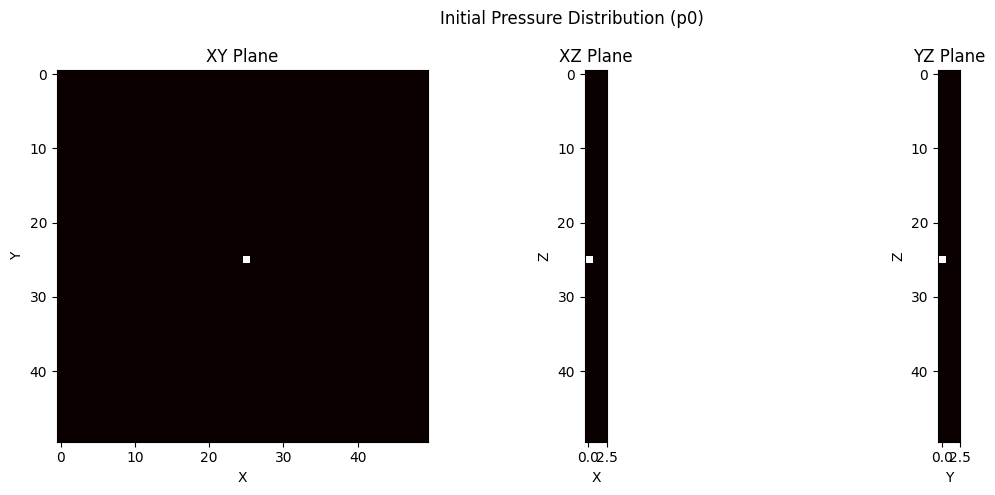

In [2]:
# Set up simulation
sim_params = setup_simulation(simulation_type='3D', source_position='center')

visualize_source(sim_params)

Point sensor created!


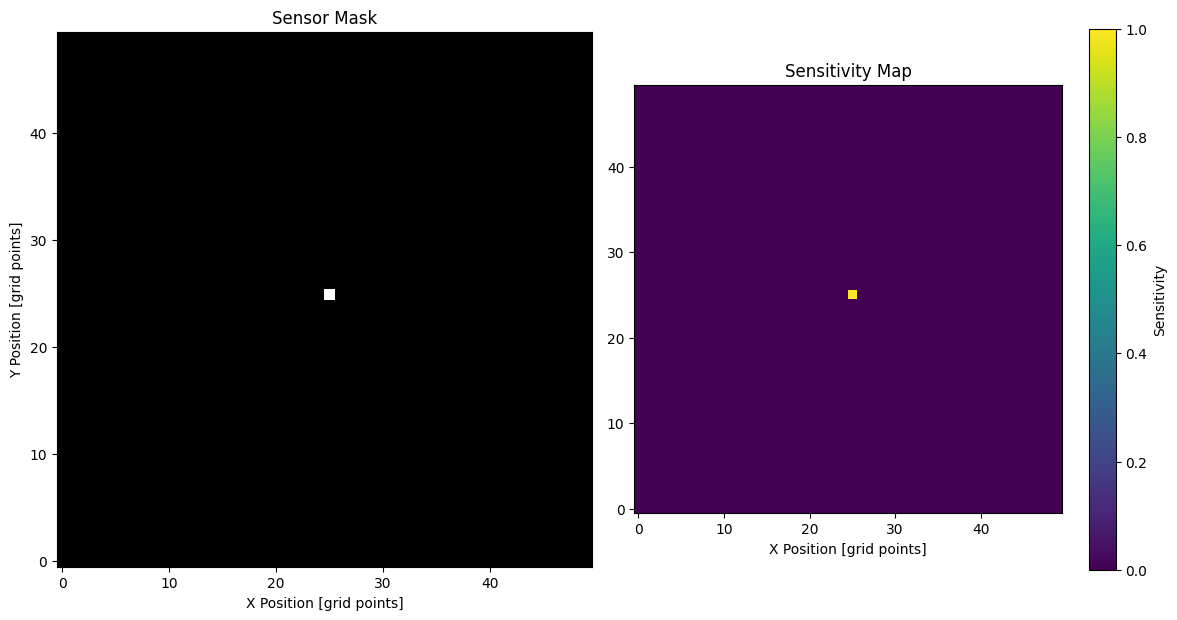

In [3]:
# Create sensor with Gaussian sensitivity
sensor = create_sensor_3D(
    sensor_type=1, 
    sim_params=sim_params
)

plot_sensor_sensitivity(sensor, sim_params)

In [4]:
# Run simulation and apply sensitivity
sensor_data = run_simulation(sim_params, sensor)
sensor_data['p'] = sensor_data['p'].reshape(-1,1)

┌───────────────────────────────────────────────────────────────┐
│                   kspaceFirstOrder-OMP v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Number of CPU threads:                                    128 │
│ Processor name:      Intel(R) Xeon(R) Gold 6338 CPU @ 2.00GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                               70 x 70 x 23 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    291 │
├───────────────────────────────────────────────────────────────┤
│                        Initialization                         │
├───────────────────────────────────────────────────────────────┤
│ Memory a

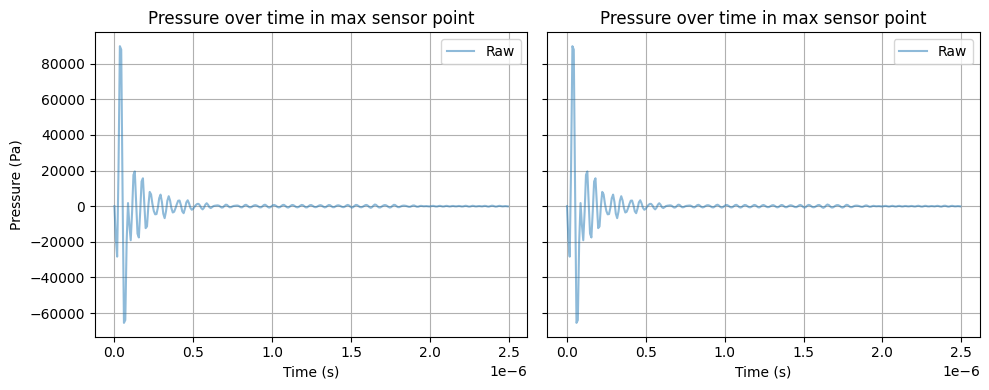

In [5]:
# Extraction sensor recording and applying the sensitivity of the sensor
sensor_mask_original_size = np.squeeze(sensor.mask[sim_params['pml_size']:-sim_params['pml_size'], sim_params['pml_size']:-sim_params['pml_size'], sim_params['sensor_plane']])
mask_flat, weighted_p, info_dict = process_sensor_data(sensor_mask_original_size, sensor.sensitivity_map, sensor_data['p'])

max_pos, min_non_zero_pos, sensor_idx_max, sensor_idx_min = find_sensitivity_extremes(info_dict, sensor.sensitivity_map)


plot_raw_pressure(
    raw_data      = sensor_data,
    weighted_data = weighted_p,
    kgrid         = sim_params['kgrid'],
    sensor_indices= [sensor_idx_max, sensor_idx_min]
)

In [6]:
performance_metrics = analyze_sensor_performance(
        p_data=sensor_data['p'],
        t_array=sim_params['kgrid'].t_array[0],
        sensor_mask=sensor_mask_original_size,
        sensitivity_map=sensor.sensitivity_map if hasattr(sensor, 'sensitivity_map') else None
    )

# Print aggregate results
print("\nAggregate Sensor Performance:")
for k, v in performance_metrics['aggregate_metrics'].items():
    print(f"{k:>20}: {v:.4e}")

# Access individual point metrics
print("\nFirst sensor point details:")
for k, v in performance_metrics['point_metrics'][0].items():
    print(f"{k:>20}: {v:.4e}")


Aggregate Sensor Performance:
  mean_peak_pressure: 8.9833e+04
   std_peak_pressure: 0.0000e+00
   max_peak_pressure: 8.9833e+04
        total_energy: 2.5058e+02
   energy_uniformity: 0.0000e+00
   mean_time_to_peak: 3.4400e-08

First sensor point details:
weighted_peak_pressure: 8.9833e+04
weighted_time_to_peak: 3.4400e-08
weighted_peak_to_peak: 1.5534e+05
     weighted_energy: 2.5058e+02
weighted_signal_duration: 2.5800e-08
weighted_dominant_frequency: 2.1178e+07
weighted_rms_pressure: 1.0006e+04


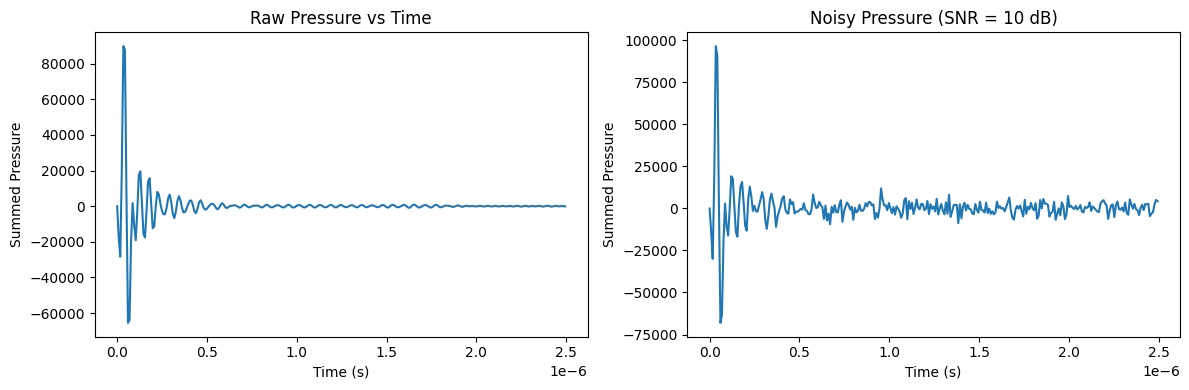

In [7]:
plot_presure_and_noise_presure_over_time(weighted_p, sim_params['kgrid'], snr_db=10)

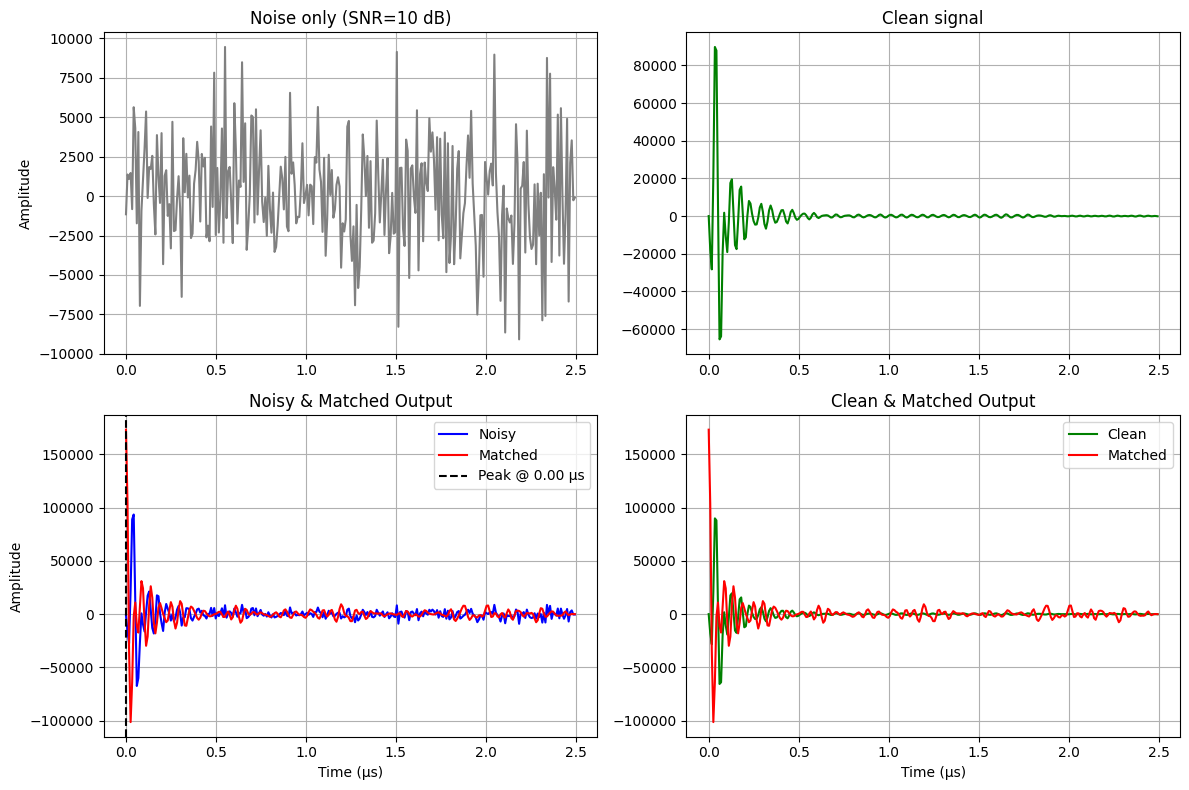

In [8]:
match_filter_results = apply_match_filter(weighted_p, sim_params['kgrid'], snr_db=10)
plot_match_filter_results(match_filter_results, sim_params['kgrid'].t_array.flatten(), snr_db=10)

In [9]:
# Calculate fundamental metrics
detector_metrics = calculate_detector_metrics(
    p_data=weighted_p,
    noise_data=match_filter_results['noise_only'],
    source_pressure=1e6,
    detector_area=np.sum(sensor_mask_original_size) * (sim_params['kgrid'].dx ** 2),
    bandwidth=1/(2*sim_params['kgrid'].dt)  # Nyquist bandwidth
)

compare_detection_performance_results = compare_detection_thresholds(
    p_data=weighted_p,
    kgrid=sim_params['kgrid'],
    source_pressure=1e6,
    snr_db=10)

print_detector_metrics(detector_metrics, compare_detection_performance_results)


=== DETECTOR PERFORMANCE METRICS ===
Noise Equivalent Pressure (NEP)    : 3.63e+04 Pa
Detectivity (D*)                   : 9.02e-06 Jones
Noise Floor                        : 3.26e+03 Pa
Responsivity                       : 8.97e-02 (output/Pa)
Signal Response                    : 8.97e+04 Pa

=== DETECTION THRESHOLD COMPARISON ===
Raw Detection Threshold (5σ)       : 1.81e+05 Pa
Filtered Detection Threshold (5σ)  : 9.11e+04 Pa
SNR Improvement                    : 27.5 → 54.9
Effective Improvement Factor       : 2.0x


# Linear sensor with Gaussian sensitivity distribution

t end: 2.5012473272817233e-06
Linear gaussian sensor created!


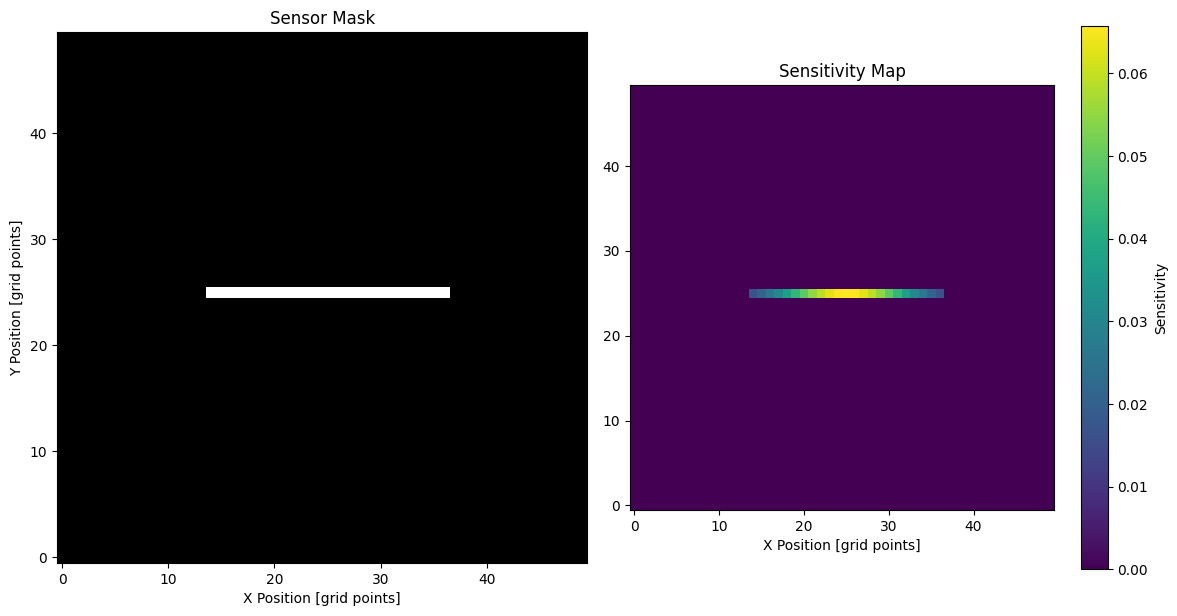

In [11]:
# Set up simulation
sim_params = setup_simulation(simulation_type='3D', source_position='center')


# Create sensor with Gaussian sensitivity
sensor = create_sensor_3D(
    sensor_type=3, 
    sim_params=sim_params,
    length=1e-3,
    width=1e-3,
    sigma=0.3e-3,
    distribution='gaussian'
)

plot_sensor_sensitivity(sensor, sim_params)

In [12]:
# Run simulation and apply sensitivity
sensor_data = run_simulation(sim_params, sensor)

┌───────────────────────────────────────────────────────────────┐
│                   kspaceFirstOrder-OMP v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Number of CPU threads:                                    128 │
│ Processor name:      Intel(R) Xeon(R) Gold 6338 CPU @ 2.00GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                               70 x 70 x 23 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    291 │
├───────────────────────────────────────────────────────────────┤
│                        Initialization                         │
├───────────────────────────────────────────────────────────────┤
│ Memory a

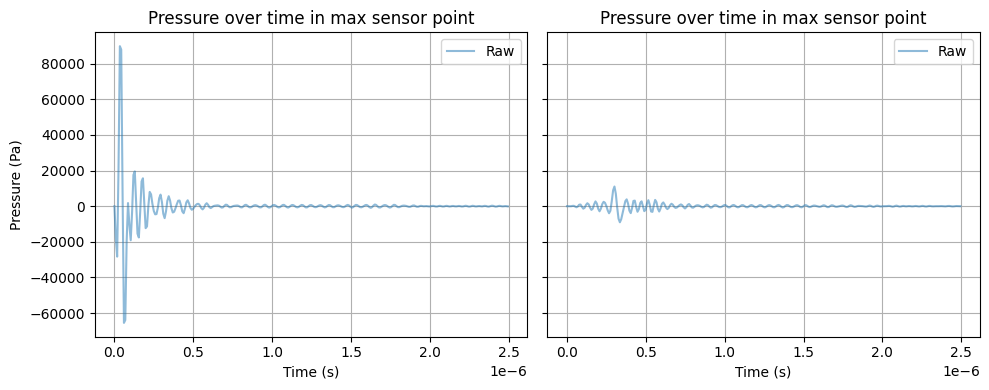

In [13]:
# Extraction sensor recording and applying the sensitivity of the sensor
sensor_mask_original_size = np.squeeze(sensor.mask[sim_params['pml_size']:-sim_params['pml_size'], sim_params['pml_size']:-sim_params['pml_size'], sim_params['sensor_plane']])
mask_flat, weighted_p, info_dict = process_sensor_data(sensor_mask_original_size, sensor.sensitivity_map, sensor_data['p'])

max_pos, min_non_zero_pos, sensor_idx_max, sensor_idx_min = find_sensitivity_extremes(info_dict, sensor.sensitivity_map)

plot_raw_pressure(
    raw_data      = sensor_data,
    weighted_data = weighted_p,
    kgrid         = sim_params['kgrid'],
    sensor_indices= [sensor_idx_max, sensor_idx_min]
)

In [14]:
results = analyze_sensor_performance(
    p_data=sensor_data['p'],
    t_array=sim_params['kgrid'].t_array[0],
    sensor_mask=sensor_mask_original_size,
    sensitivity_map=sensor.sensitivity_map if hasattr(sensor, 'sensitivity_map') else None
)

# Print aggregate results
print("\nAggregate Sensor Performance:")
for k, v in results['aggregate_metrics'].items():
    print(f"{k:>20}: {v:.4e}")

# Access individual point metrics
print("\nFirst sensor point details:")
for k, v in results['point_metrics'][0].items():
    print(f"{k:>20}: {v:.4e}")


Aggregate Sensor Performance:
  mean_peak_pressure: 1.7177e+03
   std_peak_pressure: 1.6680e+03
   max_peak_pressure: 5.9095e+03
        total_energy: 4.6201e+00
   energy_uniformity: 1.4395e+00
   mean_time_to_peak: 1.7723e-07

First sensor point details:
weighted_peak_pressure: 1.8107e+02
weighted_time_to_peak: 3.0100e-07
weighted_peak_to_peak: 3.2924e+02
     weighted_energy: 1.7227e-03
weighted_signal_duration: 3.4400e-08
weighted_dominant_frequency: 1.7182e+07
weighted_rms_pressure: 2.6237e+01


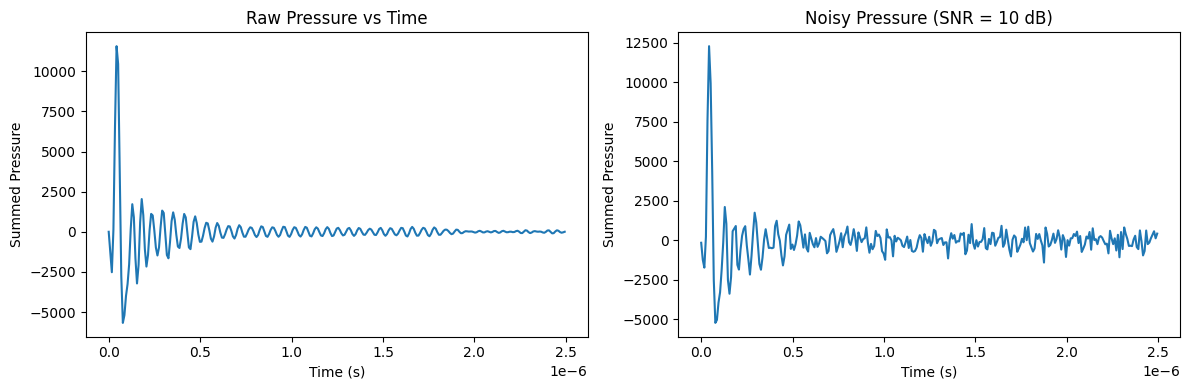

In [15]:
plot_presure_and_noise_presure_over_time(weighted_p, sim_params['kgrid'], snr_db=10)

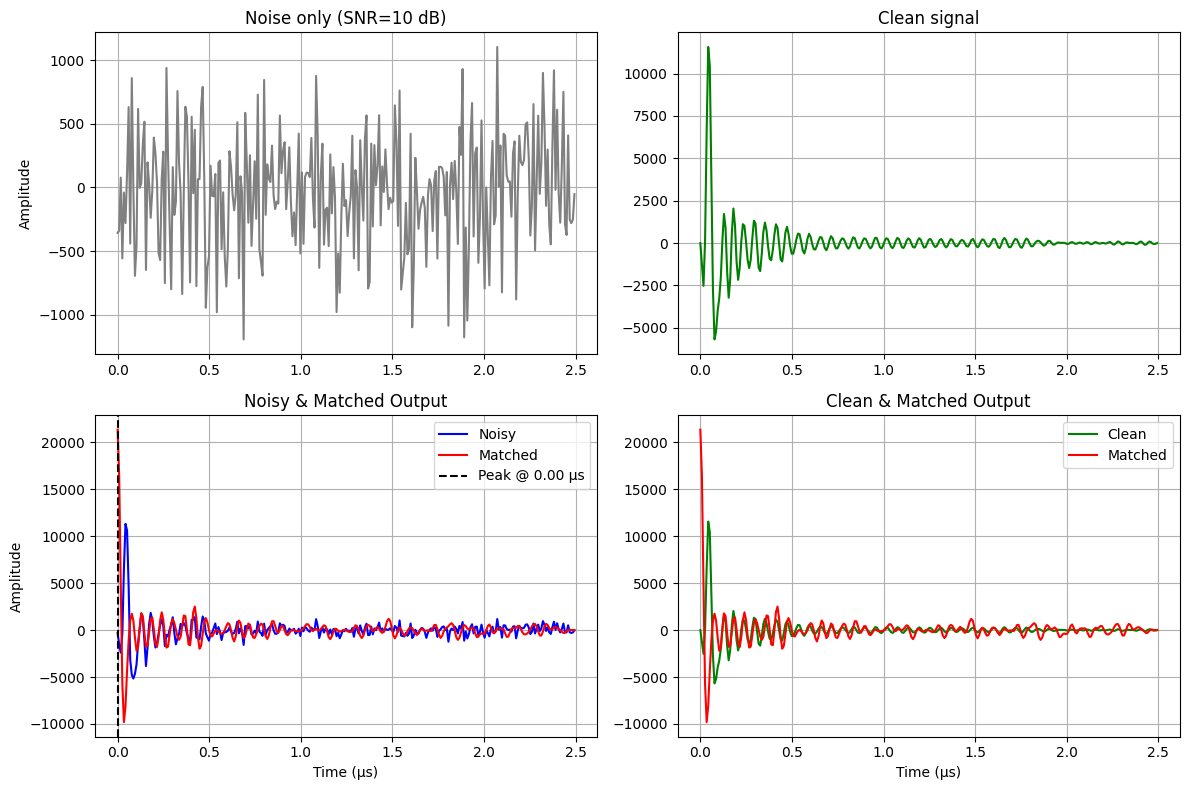

In [16]:
match_filter_results = apply_match_filter(weighted_p, sim_params['kgrid'], snr_db=10)
plot_match_filter_results(match_filter_results, sim_params['kgrid'].t_array.flatten(), snr_db=10)

In [17]:
# Calculate fundamental metrics
detector_metrics = calculate_detector_metrics(
    p_data=weighted_p,
    noise_data=match_filter_results['noise_only'],
    source_pressure=1e6,
    detector_area=np.sum(sensor_mask_original_size) * (sim_params['kgrid'].dx ** 2),
    bandwidth=1/(2*sim_params['kgrid'].dt)  # Nyquist bandwidth
)

compare_detection_performance_results = compare_detection_thresholds(
    p_data=weighted_p,
    kgrid=sim_params['kgrid'],
    source_pressure=1e6,
    snr_db=10)

print_detector_metrics(detector_metrics, compare_detection_performance_results)


=== DETECTOR PERFORMANCE METRICS ===
Noise Equivalent Pressure (NEP)    : 7.36e+04 Pa
Detectivity (D*)                   : 2.14e-05 Jones
Noise Floor                        : 4.38e+02 Pa
Responsivity                       : 5.95e-03 (output/Pa)
Signal Response                    : 5.95e+03 Pa

=== DETECTION THRESHOLD COMPARISON ===
Raw Detection Threshold (5σ)       : 1.85e+05 Pa
Filtered Detection Threshold (5σ)  : 8.85e+04 Pa
SNR Improvement                    : 27.0 → 56.5
Effective Improvement Factor       : 2.1x


# Snake-shaped Linear sensor with Uniform sensitivity distribution

t end: 2.5012473272817233e-06
Rectangular uniform sensor created!


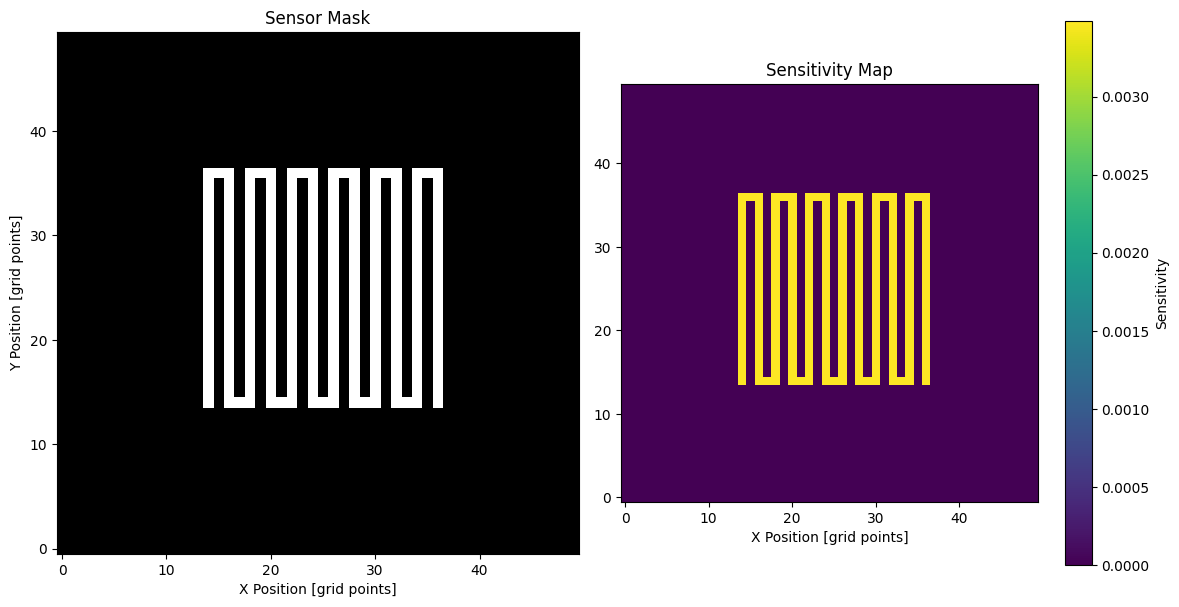

In [18]:
# Set up simulation
sim_params = setup_simulation(simulation_type='3D', source_position='center')

# Create sensor with Gaussian sensitivity
sensor = create_sensor_3D(
    sensor_type=8, 
    sim_params=sim_params,
    length=1e-3,
    width=1e-3,
    sigma=0.3e-3,
    distribution='uniform',
    row_spacing=0
)

plot_sensor_sensitivity(sensor, sim_params)

In [19]:
# Run simulation and apply sensitivity
sensor_data = run_simulation(sim_params, sensor)

┌───────────────────────────────────────────────────────────────┐
│                   kspaceFirstOrder-OMP v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Number of CPU threads:                                    128 │
│ Processor name:      Intel(R) Xeon(R) Gold 6338 CPU @ 2.00GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                               70 x 70 x 23 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    291 │
├───────────────────────────────────────────────────────────────┤
│                        Initialization                         │
├───────────────────────────────────────────────────────────────┤
│ Memory a

(24, 25) (14, 14)


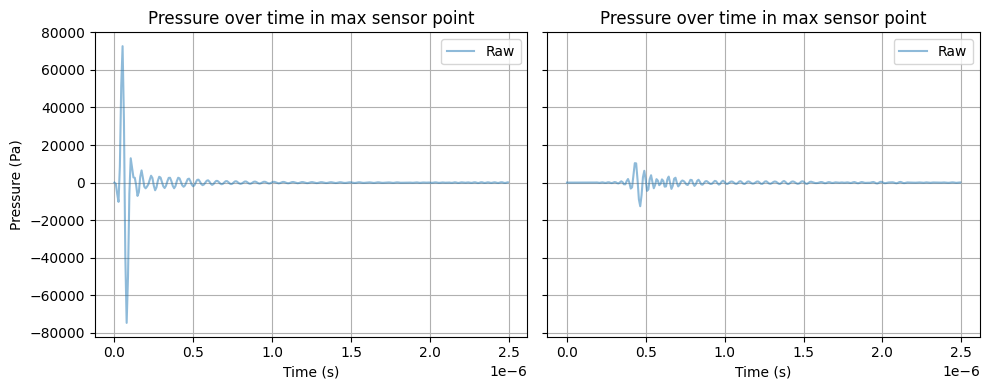

In [20]:
# Extraction sensor recording and applying the sensitivity of the sensor
sensor_mask_original_size = np.squeeze(sensor.mask[sim_params['pml_size']:-sim_params['pml_size'], sim_params['pml_size']:-sim_params['pml_size'], sim_params['sensor_plane']])
mask_flat, weighted_p, info_dict = process_sensor_data(sensor_mask_original_size, sensor.sensitivity_map, sensor_data['p'])

max_pos, min_non_zero_pos, sensor_idx_max, sensor_idx_min = find_sensitivity_extremes(info_dict, sensor.sensitivity_map)
print(max_pos, min_non_zero_pos)


plot_raw_pressure(
    raw_data      = sensor_data,
    weighted_data = weighted_p,
    kgrid         = sim_params['kgrid'],
    sensor_indices= [sensor_idx_max, sensor_idx_min])

In [21]:
results = analyze_sensor_performance(
    p_data=sensor_data['p'],
    t_array=sim_params['kgrid'].t_array[0],
    sensor_mask=sensor_mask_original_size,
    sensitivity_map=sensor.sensitivity_map if hasattr(sensor, 'sensitivity_map') else None
)

# Print aggregate results
print("\nAggregate Sensor Performance:")
for k, v in results['aggregate_metrics'].items():
    print(f"{k:>20}: {v:.4e}")

# Access individual point metrics
print("\nFirst sensor point details:")
for k, v in results['point_metrics'][0].items():
    print(f"{k:>20}: {v:.4e}")


Aggregate Sensor Performance:
  mean_peak_pressure: 7.6156e+01
   std_peak_pressure: 5.6003e+01
   max_peak_pressure: 3.2323e+02
        total_energy: 8.6923e-02
   energy_uniformity: 1.5737e+00
   mean_time_to_peak: 2.6372e-07

First sensor point details:
weighted_peak_pressure: 4.3794e+01
weighted_time_to_peak: 4.6440e-07
weighted_peak_to_peak: 7.9912e+01
     weighted_energy: 7.8350e-05
weighted_signal_duration: 6.0200e-08
weighted_dominant_frequency: 1.9979e+07
weighted_rms_pressure: 5.5953e+00


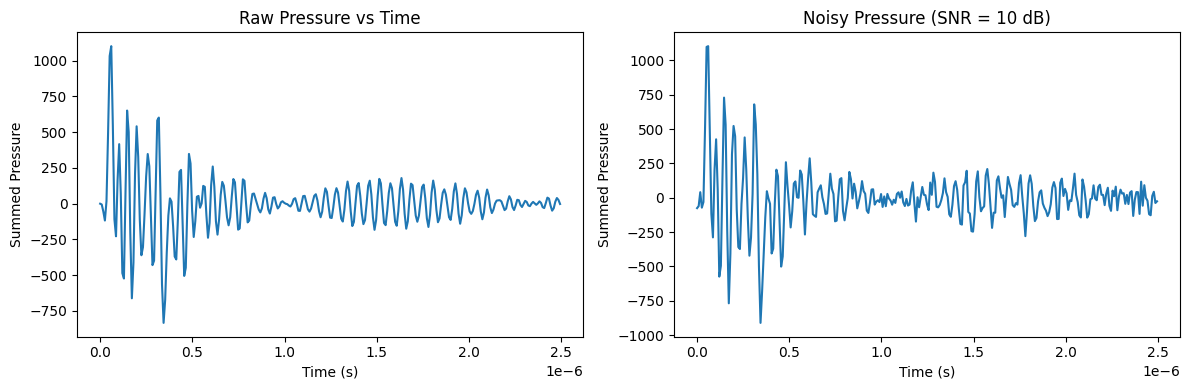

In [22]:
plot_presure_and_noise_presure_over_time(weighted_p, sim_params['kgrid'], snr_db=10)

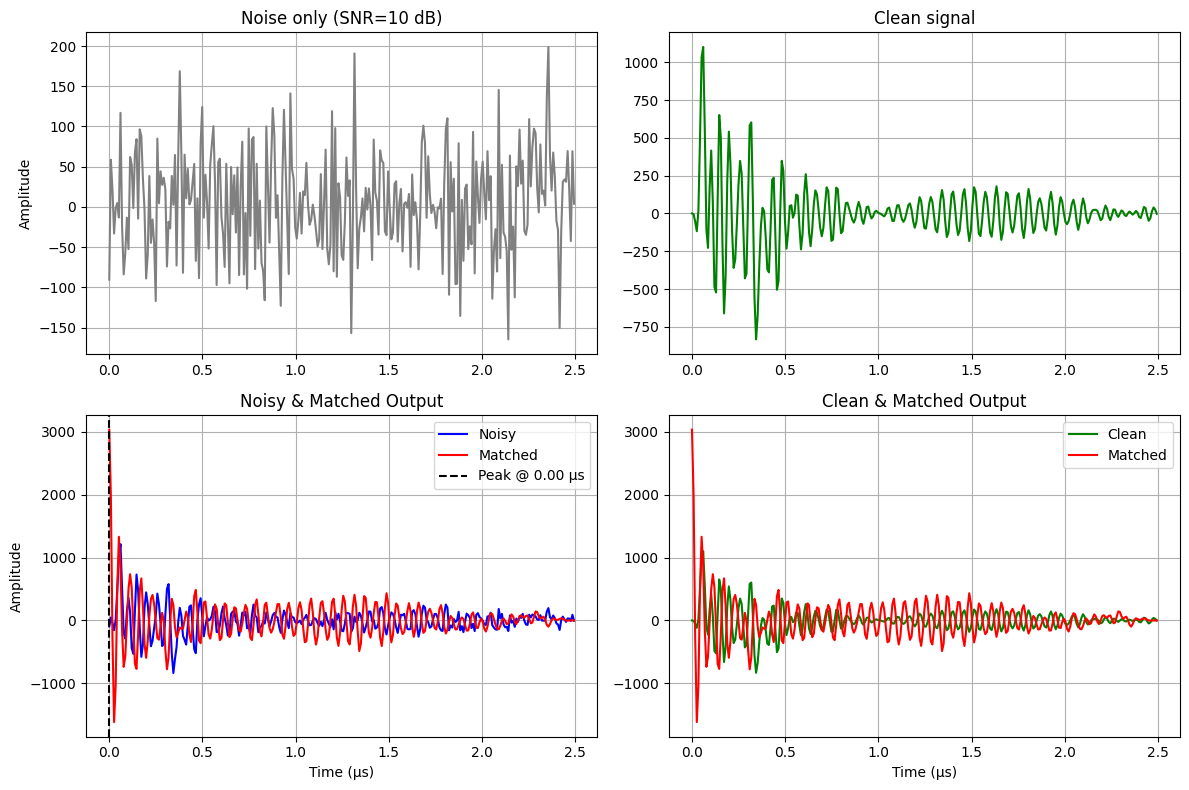

In [23]:
match_filter_results = apply_match_filter(weighted_p, sim_params['kgrid'], snr_db=10)
plot_match_filter_results(match_filter_results, sim_params['kgrid'].t_array.flatten(), snr_db=10)

In [24]:
# Calculate fundamental metrics
detector_metrics = calculate_detector_metrics(
    p_data=weighted_p,
    noise_data=match_filter_results['noise_only'],
    source_pressure=1e6,
    detector_area=np.sum(sensor_mask_original_size) * (sim_params['kgrid'].dx ** 2),
    bandwidth=1/(2*sim_params['kgrid'].dt)  # Nyquist bandwidth
)

compare_detection_performance_results = compare_detection_thresholds(
    p_data=weighted_p,
    kgrid=sim_params['kgrid'],
    source_pressure=1e6,
    snr_db=10)

print_detector_metrics(detector_metrics, compare_detection_performance_results)


=== DETECTOR PERFORMANCE METRICS ===
Noise Equivalent Pressure (NEP)    : 2.51e+05 Pa
Detectivity (D*)                   : 2.21e-05 Jones
Noise Floor                        : 6.21e+01 Pa
Responsivity                       : 2.47e-04 (output/Pa)
Signal Response                    : 2.47e+02 Pa

=== DETECTION THRESHOLD COMPARISON ===
Raw Detection Threshold (5σ)       : 2.98e+05 Pa
Filtered Detection Threshold (5σ)  : 9.77e+04 Pa
SNR Improvement                    : 16.8 → 51.2
Effective Improvement Factor       : 3.1x


# rectangular + checkerboard sensor with Gaussian sensitivity distribution + source Diagonal Offset

t end: 2.5012473272817233e-06


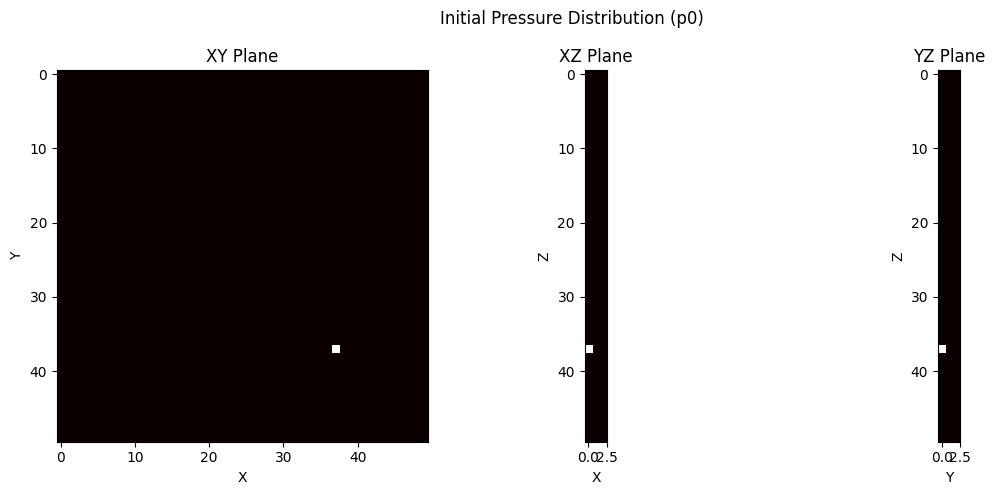

In [25]:
# Set up simulation
sim_params = setup_simulation(simulation_type='3D', source_position='diagonal_offset')

visualize_source(sim_params)

Rectangular gaussian sensor created!


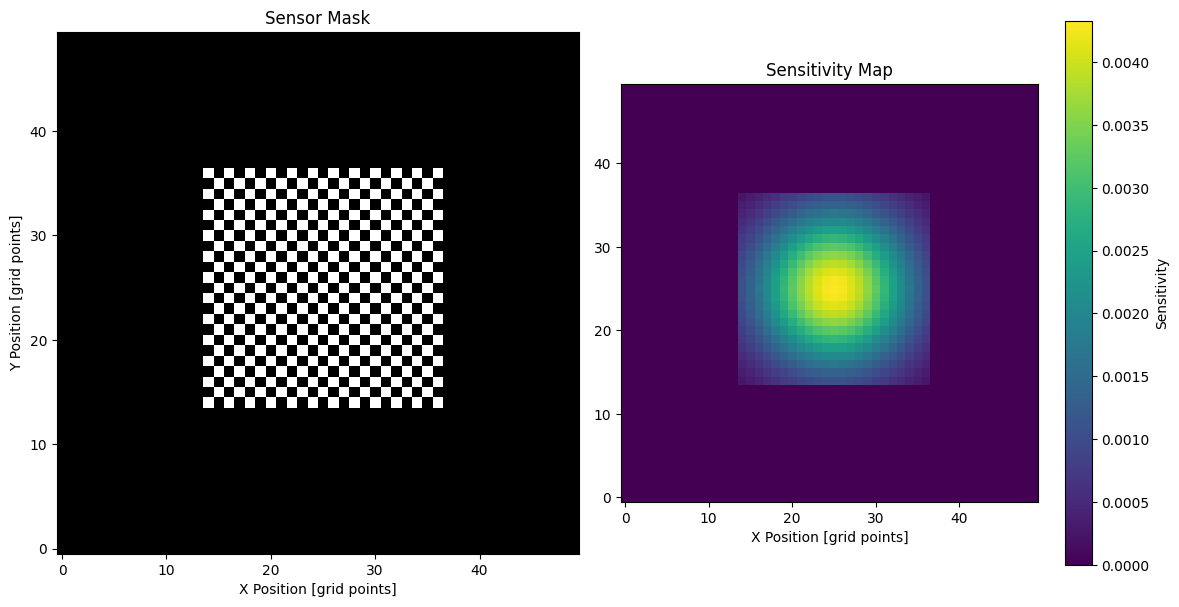

In [26]:
# Create sensor with Gaussian sensitivity
sensor = create_sensor_3D(
    sensor_type=9, 
    sim_params=sim_params,
    length=1e-3,
    width=1e-3,
    sigma=0.3e-3,
    distribution='gaussian'
)

plot_sensor_sensitivity(sensor, sim_params)

In [27]:
# Run simulation and apply sensitivity
sensor_data = run_simulation(sim_params, sensor)

┌───────────────────────────────────────────────────────────────┐
│                   kspaceFirstOrder-OMP v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Number of CPU threads:                                    128 │
│ Processor name:      Intel(R) Xeon(R) Gold 6338 CPU @ 2.00GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                               70 x 70 x 23 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    291 │
├───────────────────────────────────────────────────────────────┤
│                        Initialization                         │
├───────────────────────────────────────────────────────────────┤
│ Memory a

(25, 25) (14, 14)


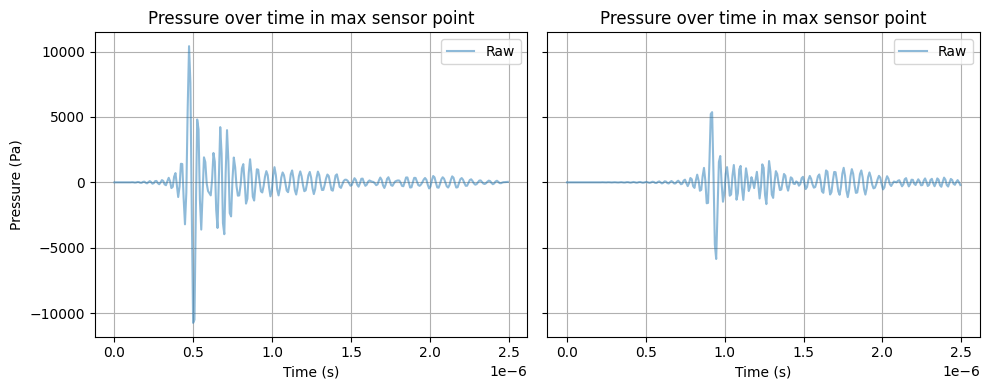

In [28]:
# Extraction sensor recording and applying the sensitivity of the sensor
sensor_mask_original_size = np.squeeze(sensor.mask[sim_params['pml_size']:-sim_params['pml_size'], sim_params['pml_size']:-sim_params['pml_size'], sim_params['sensor_plane']])
mask_flat, weighted_p, info_dict = process_sensor_data(sensor_mask_original_size, sensor.sensitivity_map, sensor_data['p'])

max_pos, min_non_zero_pos, sensor_idx_max, sensor_idx_min = find_sensitivity_extremes(info_dict, sensor.sensitivity_map)
print(max_pos, min_non_zero_pos)


plot_raw_pressure(
    raw_data      = sensor_data,
    weighted_data = weighted_p,
    kgrid         = sim_params['kgrid'],
    sensor_indices= [sensor_idx_max, sensor_idx_min])

In [29]:
results = analyze_sensor_performance(
    p_data=sensor_data['p'],
    t_array=sim_params['kgrid'].t_array[0],
    sensor_mask=sensor_mask_original_size,
    sensitivity_map=sensor.sensitivity_map if hasattr(sensor, 'sensitivity_map') else None
)

# Print aggregate results
print("\nAggregate Sensor Performance:")
for k, v in results['aggregate_metrics'].items():
    print(f"{k:>20}: {v:.4e}")

# Access individual point metrics
print("\nFirst sensor point details:")
for k, v in results['point_metrics'][0].items():
    print(f"{k:>20}: {v:.4e}")


Aggregate Sensor Performance:
  mean_peak_pressure: 1.8843e+01
   std_peak_pressure: 1.3534e+01
   max_peak_pressure: 5.4356e+01
        total_energy: 6.2604e-03
   energy_uniformity: 1.2093e+00
   mean_time_to_peak: 5.1866e-07

First sensor point details:
weighted_peak_pressure: 1.5766e+00
weighted_time_to_peak: 9.4600e-07
weighted_peak_to_peak: 3.0211e+00
     weighted_energy: 1.2122e-07
weighted_signal_duration: 2.5800e-08
weighted_dominant_frequency: 1.9180e+07
weighted_rms_pressure: 2.2010e-01


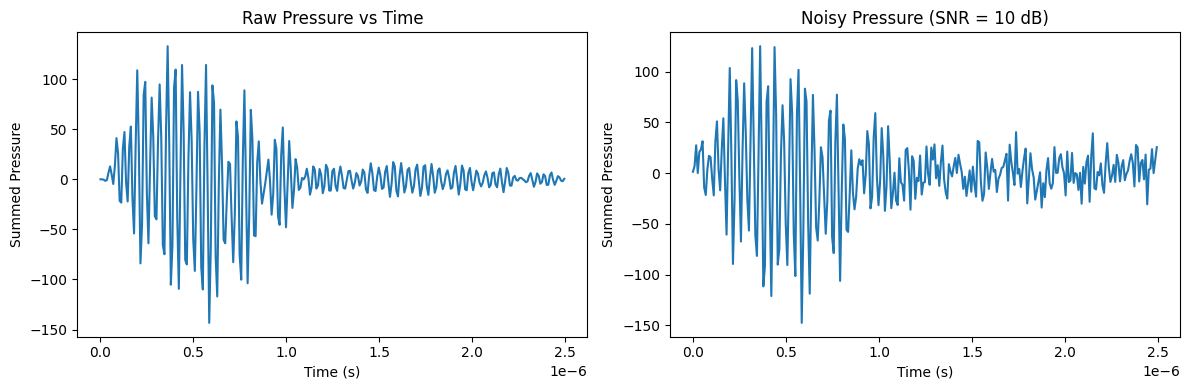

In [30]:
plot_presure_and_noise_presure_over_time(weighted_p, sim_params['kgrid'], snr_db=10)

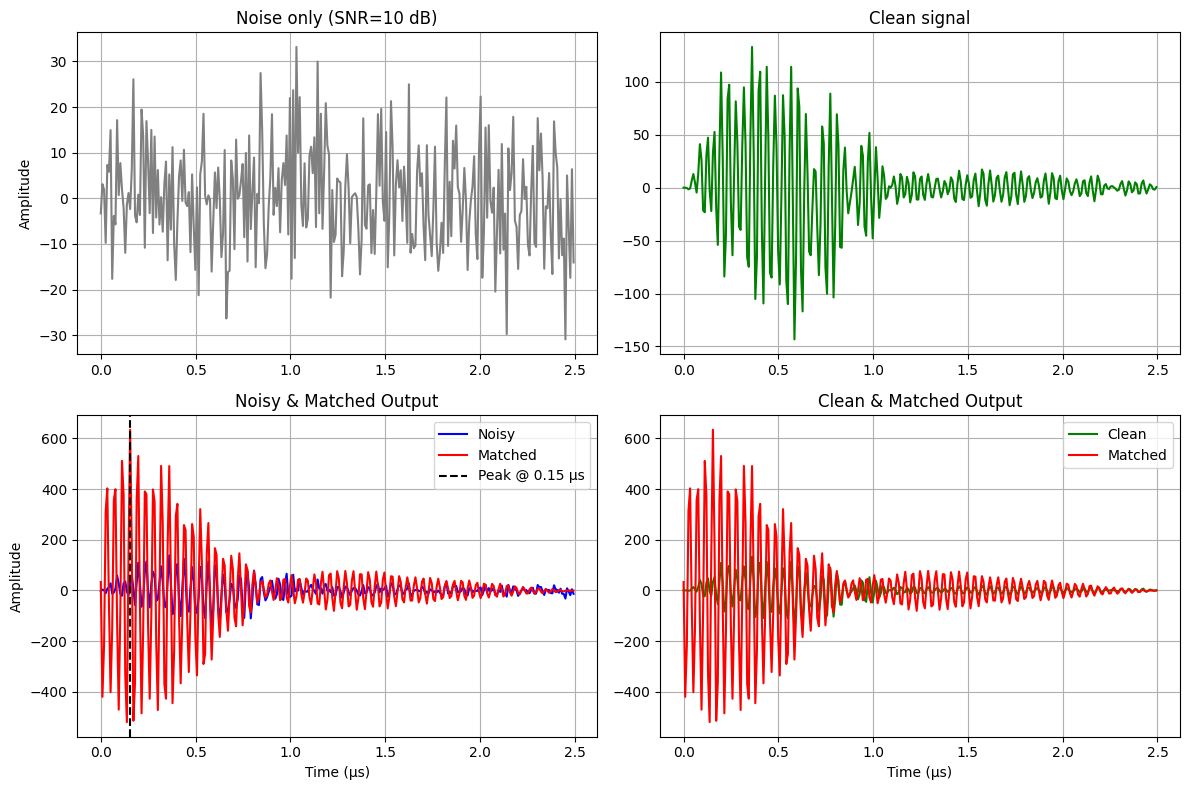

In [31]:
match_filter_results = apply_match_filter(weighted_p, sim_params['kgrid'], snr_db=10)
plot_match_filter_results(match_filter_results, sim_params['kgrid'].t_array.flatten(), snr_db=10)

In [32]:
# Calculate fundamental metrics
detector_metrics = calculate_detector_metrics(
    p_data=weighted_p,
    noise_data=match_filter_results['noise_only'],
    source_pressure=1e6,
    detector_area=np.sum(sensor_mask_original_size) * (sim_params['kgrid'].dx ** 2),
    bandwidth=1/(2*sim_params['kgrid'].dt)  # Nyquist bandwidth
)

compare_detection_performance_results = compare_detection_thresholds(
    p_data=weighted_p,
    kgrid=sim_params['kgrid'],
    source_pressure=1e6,
    snr_db=10)

print_detector_metrics(detector_metrics, compare_detection_performance_results)


=== DETECTOR PERFORMANCE METRICS ===
Noise Equivalent Pressure (NEP)    : 2.20e+05 Pa
Detectivity (D*)                   : 2.43e-05 Jones
Noise Floor                        : 1.10e+01 Pa
Responsivity                       : 5.00e-05 (output/Pa)
Signal Response                    : 5.00e+01 Pa

=== DETECTION THRESHOLD COMPARISON ===
Raw Detection Threshold (5σ)       : 4.60e+05 Pa
Filtered Detection Threshold (5σ)  : 9.43e+04 Pa
SNR Improvement                    : 10.9 → 53.0
Effective Improvement Factor       : 4.9x
